

### Importing libraries
Python imports:

In [2]:
!pip install spacy
import spacy
import string
import re
import itertools
import csv
import shutil
import matplotlib.pyplot as plt
import zipfile
import lzma
import json
import requests
import os
import xml.etree.cElementTree as ET
import pandas as pd
import numpy as np
import seaborn as sns
import random
from nltk.corpus import stopwords 

!pip install -U spacy unidecode

from unidecode import unidecode
from spacy.matcher import Matcher 
from spacy import displacy 
from IPython.display import Image, display
import nltk
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import skipgrams
from nltk.corpus import wordnet as wn
from spacy.lang.en import English

from tqdm import tqdm
from ipywidgets import FloatProgress
%matplotlib inline


!pip install pyquery
!pip install -U gensim

import gensim
#import pyLDAvis.gensim
import pickle
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.models import CoherenceModel

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\camilla.gotta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\camilla.gotta\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\camilla.gotta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### TF-IDF over time

In [34]:
#Load data
with open("weapons.pkl", 'rb') as f:
     weapons = pickle.load(f)

In [35]:
weapons

,Text,crimes
9,guilty degree murder burglary proven guilty re...,weapons
14,robbery assault guilty armed robbery murder co...,weapons
15,following guilty degree murder conviction foll...,weapons
16,reconsideration sentence offense raised imposi...,weapons
17,following guilty degree murder sexual assault ...,weapons
...,...,...
186353,conviction degree murder prison sentence rever...,weapons
186362,dismissal conviction conviction evidentiary ag...,weapons
186363,forensic evidence raise reasonable probability...,weapons
186365,armed robbery murder tried separately followin...,weapons


In [67]:
weapons['lemmatized'] = weapons.Text.progress_apply(lambda txt:lemmatization(txt))

 30%|█████████████████████▊                                                  | 4418/14596 [6:49:52<15:44:16,  5.57s/it]


KeyboardInterrupt: 

In [ ]:
with open("weapons.pkl", "wb") as f:
    pickle.dump(weapons, f)

In [ ]:
#Load data
with open("drug.pkl", 'rb') as f:
     drug = pickle.load(f)

In [ ]:
drug

In [ ]:
drug['lemmatized'] = drug.Text.progress_apply(lambda txt:lemmatization(txt))

In [ ]:
with open("drug.pkl", "wb") as f:
    pickle.dump(drug, f)

In [ ]:
crimes = crimes[(crimes.lemmatized == 'drug') | (crimes.lemmatized =='weapons')]

In [6]:
for i in range(len(weapons)):
    weapons[i] = remove_stopwords(weapons[i])
    
for i in range(len(drug)):
    drug[i] = remove_stopwords(drug[i])

In [7]:
for i in range(len(weapons)):
    weapons[i] = ' '.join([s for s in weapons[i].split() if not (len(s) < 2 or s.isdigit() == True)])
    
for i in range(len(drug)):
    drug[i] = ' '.join([s for s in drug[i].split() if not (len(s) < 2 or s.isdigit() == True)])

In [8]:
words = set(nltk.corpus.words.words())
for i in range(len(weapons)):
    weapons[i] = ' '.join([s for s in weapons[i].split() if s in words])

words_drug = set(nltk.corpus.words.words())
for i in range(len(drug)):
    drug[i] = ' '.join([s for s in drug[i].split() if s in words])

In [9]:
tokenized_weapons = [] 
for text in weapons:
    tokenized_weapons.append(word_tokenize(text))
    
tokenized_drug = [] 
for text in drug:
    tokenized_drug.append(word_tokenize(text))

In [65]:
import sys
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [63]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Do lemmatization keeping only noun, adj
weapons_lemmatized = lemmatization(tokenized_weapons, allowed_postags=['NOUN', 'ADJ'])
drug_lemmatized = lemmatization(tokenized_drug, allowed_postags=['NOUN', 'ADJ'])

In [13]:
with open("weapons_lemmatized.pkl", "wb") as f:
    pickle.dump(weapons_lemmatized, f)
    
with open("drug_lemmatized.pkl", "wb") as f:
    pickle.dump(drug_lemmatized, f)

In [20]:
#Load data
with open("weapons_lemmatized.pkl", 'rb') as f:
     weapons_lemmatized = pickle.load(f)

#Load data
with open("drug_lemmatized.pkl", 'rb') as f:
     drug_lemmatized = pickle.load(f)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [42]:
vectorizer = CountVectorizer()
vector_weapons = vectorizer.fit_transform(weapons['Text'])

words_list = vectorizer.get_feature_names()
count_list = vector_weapons.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:10]

100%|██████████████████████████████████████████████████████████████████████████| 22075/22075 [00:05<00:00, 4158.95it/s]


,words_tot,abs_freq,rel_freq
0,evidence,173821,0.031
1,testimony,89375,0.016
2,stated,61750,0.011
3,murder,54126,0.010
4,statement,45597,0.008
5,reasonable,43609,0.008
6,guilty,42999,0.008
7,offense,41520,0.008
8,conviction,39746,0.007
9,sentence,37855,0.007


In [50]:
vectorizer = CountVectorizer()
vector_drug = vectorizer.fit_transform(drug['Text'])

words_list = vectorizer.get_feature_names()
count_list = vector_drug.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:10]

100%|██████████████████████████████████████████████████████████████████████████| 20752/20752 [00:04<00:00, 4215.52it/s]


,words_tot,abs_freq,rel_freq
0,evidence,85026,0.028
1,testimony,37036,0.012
2,stated,31126,0.010
3,statute,22326,0.007
4,reasonable,20416,0.007
5,shall,19072,0.006
6,guilty,18881,0.006
7,argument,15448,0.005
8,decision,15389,0.005
9,offense,14803,0.005


In [73]:
vectorizer = TfidfVectorizer()
vector_drug = vectorizer.fit_transform(drug['Text'])

words_list = vectorizer.get_feature_names()
count_list = vector_drug.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:10]

100%|██████████████████████████████████████████████████████████████████████████| 20752/20752 [00:02<00:00, 7852.02it/s]


,words_tot,abs_freq,rel_freq
0,evidence,780.413763,0.010
1,testimony,427.595371,0.006
2,statute,309.329958,0.004
3,stated,298.942667,0.004
4,sentence,287.653255,0.004
5,guilty,286.650479,0.004
6,shall,275.367583,0.004
7,offense,244.200383,0.003
8,conviction,243.156583,0.003
9,reasonable,241.749348,0.003


In [71]:
#Reload save pkl file
with open('opinion_data.pkl', 'rb') as f:
    opinion_data = pickle.load(f)

In [72]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(opinion_data['text'])#opinion_data'text'???
vectors = vectorizer.transform(weapons['Text'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(dense, columns=feature_names)

MemoryError: Unable to allocate 42.4 GiB for an array with shape (14596, 389696) and data type float64

In [56]:
df

,aback,abaft,abandon,abandoned,abas,abase,abattoir,abb,abbreviate,abbreviation,...,zipper,zipping,zither,zodiac,zombie,zoned,zoo,zoology,zoom,zorro
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14591,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14592,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14593,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14594,0.0,0.0,0.0,0.014967,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:

tf_idf_weapons= pd.DataFrame(dense, vectors.toarray()[0], columns=["word", "value"]).sort_values("value", ascending=False)

ValueError: Shape of passed values is (14596, 22075), indices imply (22075, 2)

In [9]:
for col in vectors.nonzero()[1]:
    print(feature_names[col], ' - ', vectors[0, col])

text  -  1.0


AttributeError: 'NoneType' object has no attribute 'sort_values'

In [ ]:
weapons = (opinion_data['text'].str.contains("|".join(weapons_crimes))) 
drug = (opinion_data['text'].str.contains("|".join(drug_crimes))) 

###  Word Frequency over time
Frequency of some words over time

In [4]:
#Reload save pkl file
with open('opinion_data.pkl', 'rb') as f:
    opinion_data = pickle.load(f)

In [15]:
opinion_data.head(5)

,id,year,name,citation,court,author,type,text
0,1156845,1996-03-27,"elsie ghere, widow of jim ghere, deceased, app...",278 ill. app. 3d 840,illinois appellate court,justice colwell,majority,justice colwell\ndelivered the opinion of the ...
1,1156786,1996-02-16,"robert l. o'neil et al., plaintiffs-appellees ...",278 ill. app. 3d 327,illinois appellate court,presiding justice zwick,majority,presiding justice zwick\ndelivered the opinion...
2,1156800,1996-02-26,"in re l.n., a minor (the people of the state o...",278 ill. app. 3d 46,illinois appellate court,justice slater,majority,justice slater\ndelivered the opinion of the c...
3,1156841,1996-02-13,"the people of the state of illinois, plaintiff...",278 ill. app. 3d 218,illinois appellate court,justice scariano,majority,justice scariano\ndelivered the opinion of the...
4,1156843,1996-03-28,"robert alan shramuk, plaintiff-appellant, v. c...",278 ill. app. 3d 745,illinois appellate court,justice geiger,majority,justice geiger\ndelivered the opinion of the c...


In [17]:
opinion_year = opinion_data[['year', 'text']]

In [18]:
opinion_year.head(5)

,year,text
0,1996-03-27,justice colwell\ndelivered the opinion of the ...
1,1996-02-16,presiding justice zwick\ndelivered the opinion...
2,1996-02-26,justice slater\ndelivered the opinion of the c...
3,1996-02-13,justice scariano\ndelivered the opinion of the...
4,1996-03-28,justice geiger\ndelivered the opinion of the c...


In [ ]:
with open("opinion_year.pkl", "wb") as f:
    pickle.dump(opinion_year, f)

In [ ]:
#Reload save pkl file
with open('opinion_year.pkl', 'rb') as f:
    opinion_year = pickle.load(f)

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
!pip install -U textblob
from textblob import TextBlob


In [20]:
#Convert publish_date into datetime64 format. Sort by date

reindexed_data = opinion_year['text']
reindexed_data.index = opinion_year['year']
reindexed_data.head()

year
1996-03-27    justice colwell\ndelivered the opinion of the ...
1996-02-16    presiding justice zwick\ndelivered the opinion...
1996-02-26    justice slater\ndelivered the opinion of the c...
1996-02-13    justice scariano\ndelivered the opinion of the...
1996-03-28    justice geiger\ndelivered the opinion of the c...
Name: text, dtype: object

In [21]:
accident = [0]*reindexed_data.shape[0]
car = [0]*reindexed_data.shape[0]
gun = [0]*reindexed_data.shape[0]
murder = [0]*reindexed_data.shape[0]
drug = [0]*reindexed_data.shape[0]
dead = [0]*reindexed_data.shape[0]

In [22]:
for i in range(reindexed_data.shape[0]):
    words = TextBlob(reindexed_data[i]).words
    for word in words:
        if word == "accident" : accident[i]=1
        if word == "car": car[i]=1
        if word == "gun": gun[i]=1
        if word == "murder": murder[i]=1   # as all headlines are in lowercase
        if word == "drug": drug[i]=1
        if word == "dead": dead[i]=1 #or word == "death": dead[i]=1 #MEGLIO FARlO CON OVERDOSE?
keywords = pd.DataFrame({'text':reindexed_data,
                        'accident':accident,
                        'car':car,
                        'gun':gun,
                        'murder':murder,
                        'drug':drug,
                        'dead':dead},
                        index=reindexed_data.index)
keywords.head()

,text,accident,car,gun,murder,drug,dead
year,,,,,,,
1996-03-27,justice colwell\ndelivered the opinion of the ...,0,0,0,0,0,0
1996-02-16,presiding justice zwick\ndelivered the opinion...,0,0,0,0,1,0
1996-02-26,justice slater\ndelivered the opinion of the c...,0,0,0,0,0,0
1996-02-13,justice scariano\ndelivered the opinion of the...,0,1,0,0,1,0
1996-03-28,justice geiger\ndelivered the opinion of the c...,0,0,0,0,0,0


In [40]:
keywords.index =  pd.to_datetime(keywords.index)

In [42]:
#Aggregate monthly frequency for keywords
monthly = keywords.resample('M').sum()
print(monthly)

            accident  car  gun  murder  drug  dead
year                                              
1771-10-31         0    1    1       0     0     0
1771-11-30         0    0    0       0     0     0
1771-12-31         0    0    0       0     0     0
1772-01-31         0    0    0       0     0     0
1772-02-29         0    0    0       0     0     0
...              ...  ...  ...     ...   ...   ...
2019-03-31        11   16   12      14    11     1
2019-04-30         3   12    3       5     8     0
2019-05-31         6    8    4       7     4     2
2019-06-30         2    8    2       3     2     1
2019-07-31         1    2    0       2     2     0

[2974 rows x 6 columns]


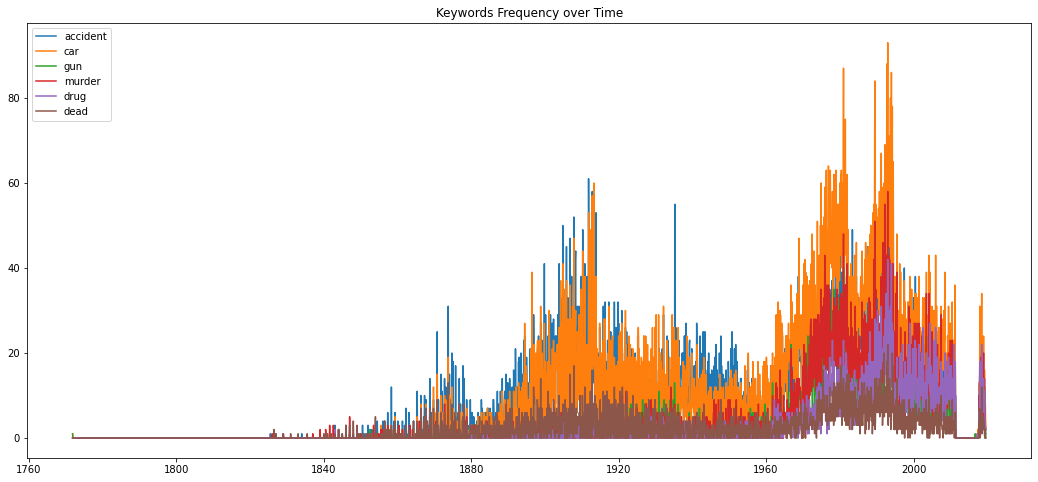

In [43]:
#Plot the frequency over time
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(monthly['accident'], label='accident');
ax.plot(monthly['car'], label='car');
ax.plot(monthly['gun'], label='gun');
ax.plot(monthly['murder'], label='murder');
ax.plot(monthly['drug'], label='drug');
ax.plot(monthly['dead'], label='dead');
ax.set_title('Keywords Frequency over Time');
ax.legend(loc='upper left');

In [44]:
yearly = keywords.resample('A').sum()

In [46]:
print(yearly)

            accident  car  gun  murder  drug  dead
year                                              
1771-12-31         0    1    1       0     0     0
1772-12-31         0    0    0       0     0     0
1773-12-31         0    0    0       0     0     0
1774-12-31         0    0    0       0     0     0
1775-12-31         0    0    0       0     0     0
...              ...  ...  ...     ...   ...   ...
2015-12-31         0    0    0       0     0     0
2016-12-31         0    0    1       0     0     0
2017-12-31        46   66   39      52    41    20
2018-12-31       114  203   98     121   131    43
2019-12-31        34   70   30      41    42     9

[249 rows x 6 columns]


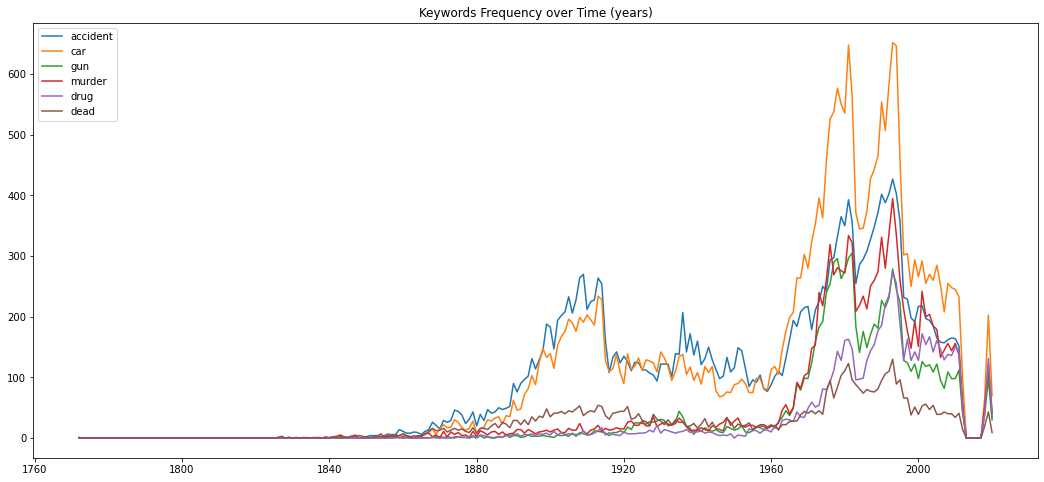

In [45]:
#Plot the frequency over time
fig, ax = plt.subplots(figsize=(18,8))

ax.plot(yearly['accident'], label='accident');
ax.plot(yearly['car'], label='car');
ax.plot(yearly['gun'], label='gun');
ax.plot(yearly['murder'], label='murder');
ax.plot(yearly['drug'], label='drug');
ax.plot(yearly['dead'], label='dead');
ax.set_title('Keywords Frequency over Time (years)');
ax.legend(loc='upper left');